In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Load training data

In [3]:
data = pd.read_csv('train.csv', sep=';')

In [4]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
445690,25/9-1,2151.758000,483525.71875,6590322.5,-2126.496826,CROMER KNOLL GP.,Roedby Fm.,8.947844,2.419868,2.196171,...,11.689734,NaN,NaN,0.032000,0.152180,2.237499,NaN,2.357654,70000,1.0
207978,17/11-1,2633.201016,520153.18750,6452287.5,-2606.201172,ZECHSTEIN GP.,Smith Bank Fm.,12.540542,101.293457,NaN,...,37.165787,NaN,NaN,-0.002015,1.366021,NaN,NaN,NaN,88000,1.0
792966,34/10-35,1379.335000,463378.46875,6771056.5,-1356.242554,HORDALAND GP.,Utsira Fm.,17.036457,NaN,0.768768,...,NaN,NaN,NaN,0.000691,NaN,NaN,NaN,NaN,65030,1.0
376458,25/6-3,1156.499729,495700.84375,6618250.0,-1131.348633,HORDALAND GP.,Skade Fm.,12.670265,NaN,1.805349,...,29.510139,308.51889,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
445892,25/9-1,2182.462000,483525.59375,6590323.0,-2157.194824,VIKING GP.,Heather Fm.,9.842032,1.021467,1.031253,...,NaN,NaN,NaN,0.173697,0.152180,0.232046,NaN,1.009162,65000,1.0
933948,34/8-1,2373.593023,469587.12500,6803786.5,-2340.521729,SHETLAND GP.,Lista Fm.,12.375001,0.130681,NaN,...,NaN,NaN,NaN,-0.009712,NaN,NaN,NaN,0.130022,65000,2.0
300170,25/3-1,2517.232000,487276.71875,6643960.0,-2494.989746,SHETLAND GP.,Vaale Fm.,12.477706,NaN,4.838885,...,10.307472,NaN,0.229535,-0.002341,2.396528,NaN,NaN,NaN,70000,1.0
647124,31/4-10,1953.468393,510289.34375,6721196.0,-1931.394653,SHETLAND GP.,Lista Fm.,12.328100,2.490460,1.588577,...,NaN,NaN,NaN,NaN,NaN,NaN,27.964659,2.507262,65000,1.0
1041294,35/11-6,3435.007600,524982.56250,6784908.5,-3406.740723,VIKING GP.,Heather Fm.,9.280700,8.436167,8.224648,...,NaN,NaN,NaN,-0.002378,NaN,NaN,NaN,NaN,65030,1.0
413544,25/8-5 S,1881.718400,463943.62500,6591242.0,-1846.689453,HORDALAND GP.,Grid Mb.,13.217046,1.080655,0.897098,...,22.428131,NaN,0.967047,0.022911,1.461882,0.231207,NaN,0.955461,65000,1.0


### 检查可用的日志和解释

数据包含元数据列
* WELL: 井名
* DEPTH_MD: 测量深度 (井口)
* X_LOC: UTM X 坐标
* Y_LOC: UTM Y 坐标
* Z_LOC: 深度 （海平面）
* GROUP: NPD 岩石地层组
* FORMATION: NPD 岩石地层构造

数据包含井口曲线。例如以下内容：
* BS: 钻头尺寸
* CALI: 测径器 `井径Caliper`
* RDEP: 深部电阻率 `Deep Resistivity`
* RHOB: 整体密度 `Bulk Density`
* GR: 原始伽马数据 `Raw gamma data`
* SGR: 光谱伽马射线 `Spectral Gamma Ray`
* RMED: 中等电阻率 `Medium Resistivity`
* ROP: 渗透率 `Rate of Penetration`
* NPHI: 中子孔隙度 `Neutron Porosity`
* PEF: 光电吸收因子 `Photoelectric Absorption Factor`
* RSHA: 浅部电阻率 `Shallow Resistivity`
* DTS: 声波（剪切慢度）`Sonic (Sheer Slowness)`
* DTC: 声波（压缩慢度）`Sonic (Compressional Slowness)`

以及解释

* FORCE_2020_LITHOFACIES_LITHOLOGY: 岩石类别标签
* FORCE_2020_LITHOFACIES_CONFIDENCE: 对岩石解释的信心（1: 高，2: 中，3: 低）

训练数据集中总共有83口井。包含`WELL`列，以便可以按照**每口井分隔**数据。对于我们在`ML features`机器学习特征中使用`non-local information`**非局部信息**的任何`windowed`“窗口化”方法来说，这将是必要的

> 岩性识别的机器学习应用背景，提到的“窗口化”方法指的是一种处理和分析数据的技术，特别是在处理序列数据或时间序列数据时。这种方法考虑了数据点的上下文信息，而不仅仅是单个数据点本身。在地质学和地球物理学的应用中，这种方法尤其重要，因为相邻的数据点（例如，来自同一口井的连续深度的数据）之间通常存在物理或地质上的联系。
> 
> 具体到这段话中，提到需要按照每口井分隔数据，这是因为每口井的数据都包含了关于那一特定地点的独特地质信息。在进行机器学习模型训练时，利用“窗口化”方法可以通过考虑一个数据点周围的其他数据点（即非局部信息）来提高模型的准确性和泛化能力。例如，如果模型在预测某一深度处的岩性时，不仅考虑该深度点的信息，而且还考虑其上下文信息（比如该点周围一定范围内的其他深度点的信息），就能更准确地理解地质结构和岩石类型的变化，从而做出更准确的预测。
> 
> 这种方法在处理具有空间连续性或时序连续性的数据时特别有用，因为它允许模型捕捉到数据中的模式和趋势，这些模式和趋势可能在局部范围内不明显，但在更大的上下文中变得重要。在岩性识别的背景下，这意味着通过考虑与目标数据点相邻的数据点的信息，机器学习模型可以更好地理解地层的变化，从而提高预测岩石类型的准确性。

In [5]:
wells = data['WELL'].unique()

In [6]:
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [7]:
len(wells)

98

Note: 原始数据提供的是：98口井的数据。但是，这座start讲的是83口井，可能进行了一些数据筛选工作。

### `LITHOLOGY`列 - 岩性标签

总结：数据集中使用LITHOLOGY列来表示岩石类型，并通过统计分析展示各岩石类型的分布情况

LITHOLOGY列包含了对岩石类型的解释。每个数字对应一个岩石类型类别，这些类别由下面的列表给出：


| 编号   | 岩石类型       |
| ------ | -------------- |
| 30000  | 砂岩（Sandstone） |
| 65030  | 砂岩/页岩（Sandstone/Shale） |
| 65000  | 页岩（Shale） |
| 80000  | 泥灰岩（Marl） |
| 74000  | 白云岩（Dolomite） |
| 70000  | 石灰岩（Limestone） |
| 70032  | 白垩（Chalk） |
| 88000  | 岩盐（Halite） |
| 86000  | 石膏（Anhydrite） |
| 99000  | 凝灰岩（Tuff） |
| 90000  | 煤（Coal） |
| 93000  | 基岩（Basement） |

In [8]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

通过data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()命令，可以查看数据集中出现的岩石类型代码，这些代码与上述列表中的代码相对应

In [9]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000])

然而，岩石类型在数据集中的出现概率并不相等。这一点反映在了数据集的统计分析中。

计算每种岩石类型的出现次数和百分比

- 首先计算每种岩石类型的出现次数（value_counts()），
- 然后计算每种类型占总数的百分比，并使用这些信息生成条形图。
- 图表的X轴是岩石类型的名称，Y轴是该岩石类型出现的百分比。
- 条形图通过旋转45度的X轴标签和设置Y轴标签为"岩石类型出现的百分比(%)"来提高可读性。

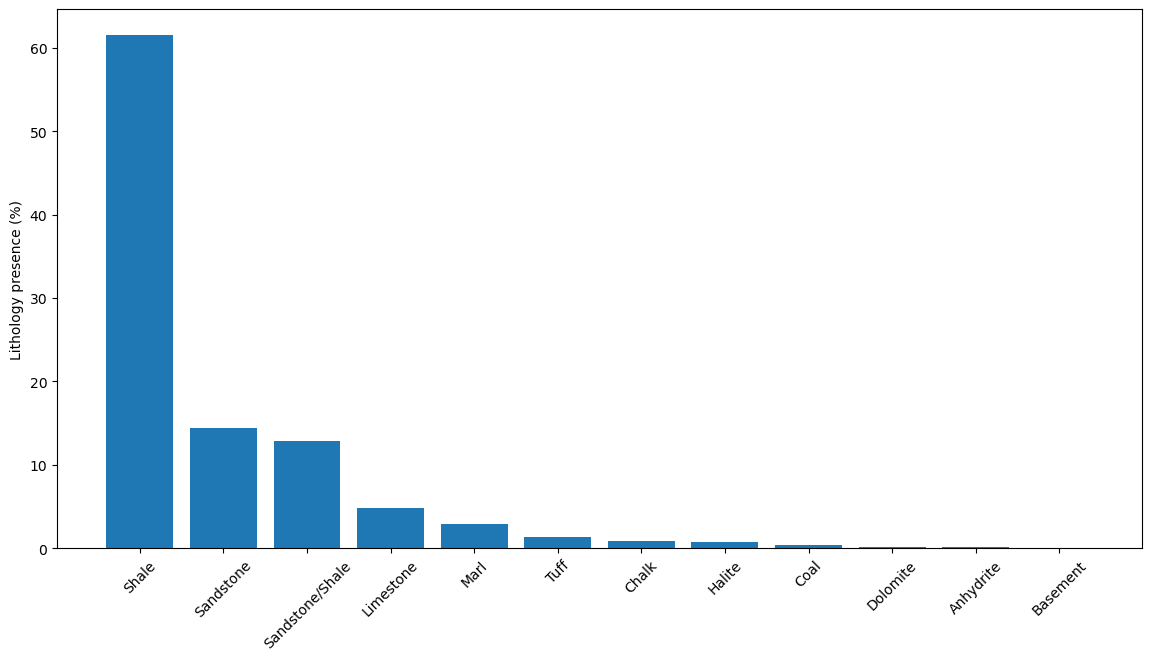

In [10]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]

for item in counts.items():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
# 先设置 x 轴的刻度，再设置标签
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel('Lithology presence (%)')

plt.show()

### 缺失曲线

强调数据集中日志曲线（测井曲线）缺失值的重要性，这是数据集和比赛的一个关键特点。在这里，作者指出除了WELL（井号）、DEPTH_MD（深度）和GR（伽马射线）这三列是保证存在的之外，其他所有的日志列都可能在数据集的某些部分缺失

除了WELL、DEPTH_MD和GR外，其他列都有可能包含NaN值，表明这些列中存在缺失值。然后，data.isna().sum()提供了每列缺失值的具体数量

In [11]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [12]:
data.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

条形图展示了训练数据中的井包含给定日志的百分比。这个可视化说明了一些日志，如RT（电阻率）和DTS（剪切波声速）在不到一半的训练井中出现。这意味着，在处理数据和训练模型时，需要对这些缺失值进行适当的处理，例如使用插值、删除缺失数据或通过其他方法预测缺失值。

/tmp/ipykernel_1050535/1631084686.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.columns[2:-2], rotation=45)


Text(0, 0.5, 'Well presence (\\%)')

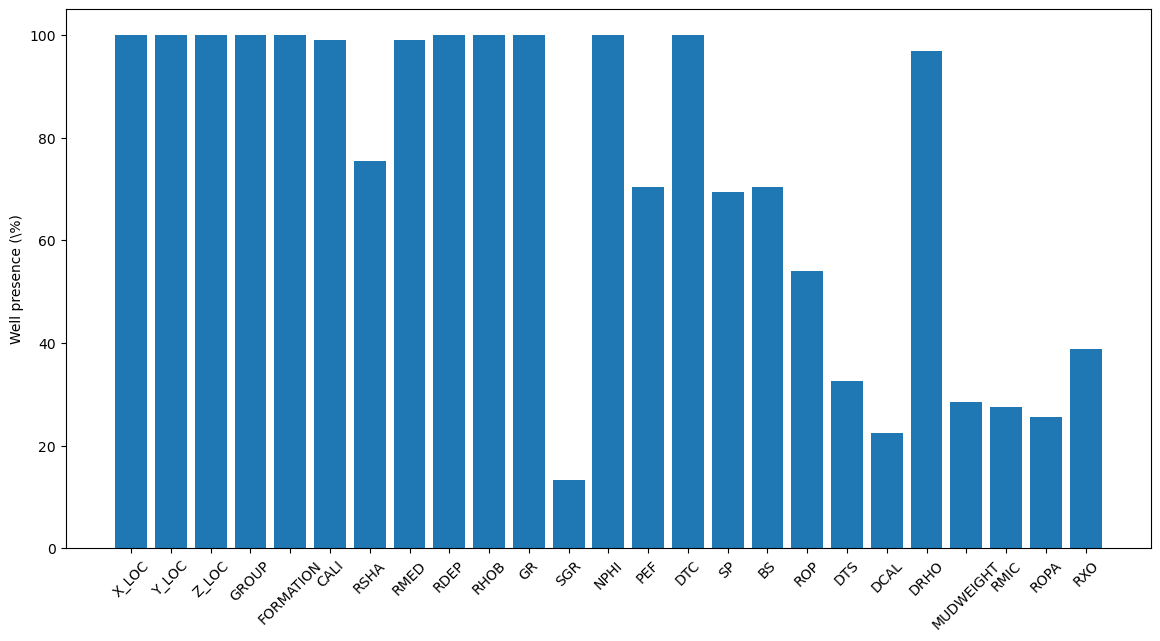

In [13]:
occurences = np.zeros(25)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

每种日志在至少某个深度区间内出现的井的百分比，通过计算数据集中唯一井号的数量减去完全缺失某日志的井的数量，再除以总井数，得到每种日志的存在率，帮助理解哪些日志数据是比较常见的，哪些较为罕见，从而可以在进行数据预处理和特征工程时做出更有信息的决策

测试数据也将有类似的可用日志分布，意味着处理训练数据中的缺失值的策略也应适用于测试数据。这对于确保模型的泛化能力和在面对不完整数据时的稳健性至关重要

#### 可视化几口井的测井曲线数据

直观地查看各种测井参数随深度变化的情况，这对于理解井下地质条件非常有帮助

选择了数据集中的某一口井（wells[0]）作为分析对象，从数据集中筛选出该井的数据。然后，使用matplotlib库创建一个子图（subplots）布局，其中每个子图对应一个测井参数。这里排除了DEPTH_MD（深度）、FORCE_2020_LITHOFACIES_LITHOLOGY（岩石类型）、FORCE_2020_LITHOFACIES_CONFIDENCE（岩石类型置信度）、WELL（井号）、GROUP（地层组）、FORMATION（地层）、X_LOC、Y_LOC、Z_LOC（位置坐标）这些列，因为它们不是用于分析的测井参数。

对于每个测井参数，使用深度作为Y轴，该参数的值作为X轴画图。这样可以直观地看到随深度变化该参数的变化情况。

(3272.024, 494.528)

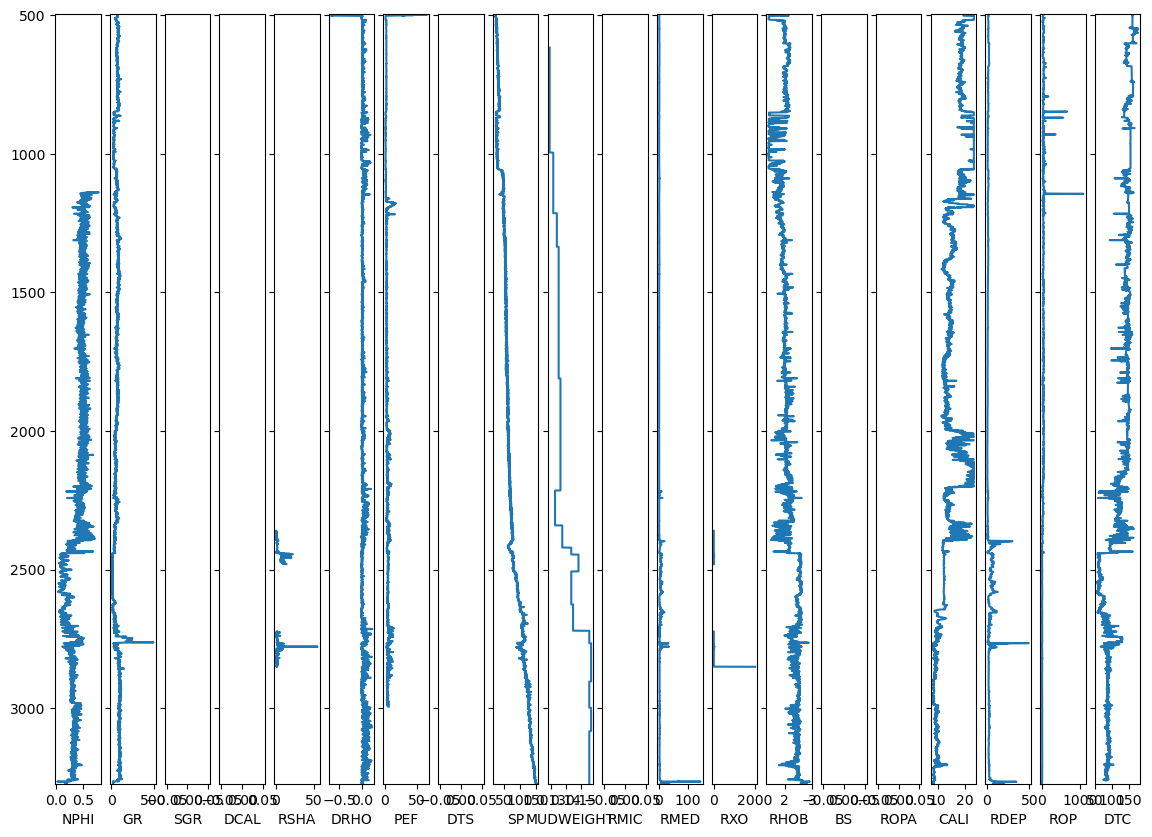

In [14]:
well_data = data[data['WELL'] == wells[0]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

重复上述步骤，但这次选择的是另一口井（wells[57]），进行相同的分析和可视化操作。

(4422.0172, 2484.1692)

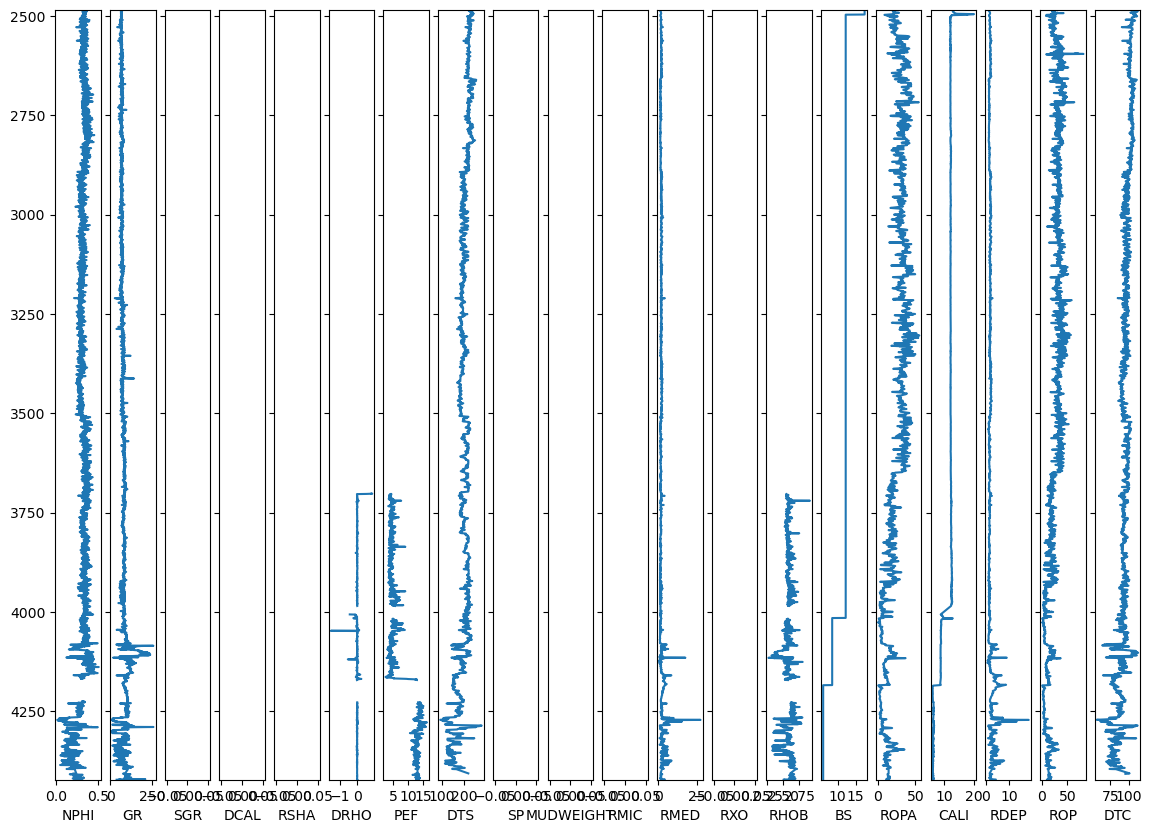

In [15]:
well_data = data[data['WELL'] == wells[57]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

可视化方法特别有用，因为它可以帮助识别出特定深度范围内的地质特征，如沉积层、岩石类型的变化等。通过对比不同井的测井曲线，可以进一步了解地下地质条件的差异性。这对于地质学家和工程师来说是一个宝贵的分析工具，可以用于解释地下的岩石物理特性，以及在勘探和开发中的决策支持。

此外，设置axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])确保了深度轴（Y轴）是从井的底部到顶部，这样的可视化更符合地质学的习惯，因为地质层序通常是从下往上分析的。

### 数据以供机器学习训练

1. 删除不必要的列：移除了不直接参与模型训练的列，比如井号(WELL)，岩石类型(FORCE_2020_LITHOFACIES_LITHOLOGY)以及岩石类型置信度(FORCE_2020_LITHOFACIES_CONFIDENCE)。剩下的列将用作模型的特征。

In [16]:
X = data.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

##### 处理缺失值


处理缺失值：将所有缺失值(NaN)替换为0。这是处理缺失数据的一种简单方法，但在实践中，你可能需要更复杂的方法（如插值或使用模型预测缺失值）来更好地保留数据的统计特性。

In [17]:
X.fillna(0, inplace=True)

#### 转换岩石类型标签为数字

这里将岩石类型的分类标签映射为从0到11的数字，便于模型处理。

In [18]:
y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [19]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [20]:
y = y.map(lithology_numbers)

##### 计算类权重：

由于岩石类型分布不均匀，可能需要计算类权重来调整模型训练，确保不会偏向于更频繁出现的类别。

In [21]:
np.bincount(y)

array([168937, 150455, 720803,  33329,   1688,  56320,  10513,   8213,
         1085,  15245,   3820,    103])

##### 数据洗牌：(shuffle) 

洗牌数据集，以确保模型训练的随机性。这对于保证模型的泛化能力和稳健性非常重要。

在分割数据前洗牌是一个好习惯，可以帮助减少数据分割时的偏差。

In [22]:
X, y = shuffle(X, y, random_state=42)

In [23]:
X

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
30423,2343.304000,436806.46875,6463010.5,-2318.007324,ROGALAND GP.,Lista Fm.,14.882113,0.771240,0.771240,0.662699,...,88.208725,12.250001,12.761565,0.000000,2.632109,0.115312,0.143792,0.000000,0.000000,0.57085
1073159,3582.467851,543919.75000,6856653.5,-3477.858154,CROMER KNOLL GP.,Roedby Fm.,8.645628,0.000000,5.599961,4.988578,...,0.000000,8.500000,10.556081,150.206314,0.000000,-0.007215,0.000000,6.627153,10.410796,0.00000
436368,734.814000,483545.34375,6590313.0,-709.762207,NORDLAND GP.,Utsira Fm.,0.000000,0.000000,0.000000,1.000559,...,0.000000,17.500000,109.271744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
290688,1075.968000,487291.25000,6643945.0,-1053.937988,HORDALAND GP.,0,17.646826,0.000000,0.867609,1.231773,...,21.596836,17.500000,7.970956,0.000000,0.215513,0.051340,0.958611,0.000000,0.000000,0.00000
1118085,3580.061600,537897.75000,6791142.5,-3069.179688,BAAT GP.,Rannoch Fm.,8.572706,0.000000,7.634528,8.066478,...,0.000000,8.500000,31.773550,140.671463,0.000000,0.039784,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,2619.545201,0.00000,0.0,0.000000,ZECHSTEIN GP.,Smith Bank Fm.,12.437759,0.000000,0.000000,0.000000,...,0.000000,12.250001,2.385924,0.000000,0.000000,0.000000,1.425934,0.000000,0.000000,0.00000
259178,3032.057901,476870.34375,6625402.0,-3008.017822,VIKING GP.,Draupne Fm.,12.151999,1.934554,1.315825,1.341654,...,58.382977,12.250001,0.000000,0.000000,-0.098000,0.037645,0.000000,0.000000,0.000000,0.00000
131932,2015.638396,476768.28125,6523588.5,-1989.272949,HEGRE GP.,Skagerrak Fm.,8.527798,0.000000,1.631037,1.619809,...,0.000000,8.500000,9.060954,172.162643,0.000000,-0.001382,0.000000,0.000000,0.000000,0.00000
671155,1424.414000,530753.68750,6732068.0,-1380.430908,ROGALAND GP.,Lista Fm.,0.000000,0.000000,0.000000,0.576554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### 选择使用的列：

这一步骤进一步缩减特征集，仅保留对模型可能有用的特征。

In [24]:
X.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI',
       'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP',
       'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO'],
      dtype='object')

In [25]:
X = X[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

##### 特征缩放：

使用标准化（或称为Z-score标准化）来缩放特征，这是提高模型性能的关键步骤，尤其是对于依赖距离计算的模型，如支持向量机(SVM)和K近邻(KNN)。

In [26]:
scaler = StandardScaler()

In [27]:
X.columns

Index(['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS'],
      dtype='object')

In [28]:
X = scaler.fit_transform(X)

##### 分割训练和测试数据

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

最后，使用train_test_split函数将数据分割为训练集和测试集，测试集占总数据的20%。这允许你在独立的数据上评估模型的性能，确保模型具有良好的泛化能力。

#### 数据处理建议

1. **更精细的缺失值处理**：
   - 使用插值方法（如线性插值、最近邻插值）来填充连续变量的缺失值，这可能比简单地用0填充保留更多信息。
   - 对于分类变量，考虑使用众数或构建一个简单的模型（如决策树）来预测和填充缺失值。

2. **特征工程**：
   - **派生特征**：考虑从现有数据中派生新特征。例如，可以计算某些测井参数的滑动平均值或梯度，以捕获沉积层的变化趋势。
   - **特征选择**：通过使用特征选择技术（如基于模型的特征选择、递归特征消除等）来识别和保留最有信息量的特征，从而减少模型复杂性并可能提高性能。

3. **考虑数据不平衡处理**：
   - 使用过采样（如SMOTE）或欠采样技术来平衡类别，这对于提高模型对少数类的识别能力可能很有帮助。
   - 计算类权重并在模型训练中使用，以弥补类别不平衡。

4. **多尺度分析**：
   - 考虑在不同尺度上分析数据，比如结合局部（小窗口）和全局（大窗口或整个井）的信息，这可能有助于捕捉更复杂的地质特征。

#### 建模灵感

1. **混合模型**：
   - 考虑将传统机器学习方法与深度学习模型结合起来，使用深度学习模型来提取高级特征，然后将这些特征与传统特征一起输入到一个轻量级的机器学习模型中进行最终的分类。

2. **序列模型**：
   - 鉴于数据本质上是按深度序列化的，可以使用RNN（循环神经网络）或LSTM（长短期记忆网络）这样的序列模型来处理这种结构化数据，这可能对于捕捉测井数据随深度变化的动态特性特别有效。

3. **图神经网络（GNN）**：
   - 如果数据可以被表示为图结构（例如，相邻井之间的关系可以构成图的边），图神经网络可以用来捕捉这种空间关系。

4. **自监督学习**：
   - 考虑使用自监督学习技术预训练模型，特别是在标签数据有限的情况下。通过设计预测任务（如预测缺失的测井参数），模型可以学习到丰富的特征表示，这些特征随后可以用于下游的监督学习任务。

5. **集成学习**：
   - 使用集成学习方法（如随机森林、梯度提升树、模型融合技术）来整合多个模型的预测，这通常能提高模型的稳定性和准确性。

这些建议和灵感可以帮助你在现有基础上进一步提升模型的性能和泛化能力，同时也可能为你后续的工作带来新的思路和方向。在应用这些方法时，建议先从数据和问题本身出发，结合实际情况逐步尝试，并通过交叉验证等技术来评估每种方法的有效性。

深度学习进行序列任务，如岩性识别，确实可以在一定程度上减少传统特征工程的工作量。深度学习模型，尤其是那些专门为序列数据设计的结构，如循环神经网络（RNN）、长短期记忆网络（LSTM）和门控循环单元（GRU），能够自动从原始数据中学习到复杂的特征表示。这减少了需要手动设计特征的必要性，让你可以更多地专注于模型的设计和优化。以下是几点深度学习在处理测井数据时的优势和考虑因素：

### 深度学习的优势

1. **自动特征提取**：深度学习模型能够自动从大量的原始数据中学习到有用的特征表示，这意味着对于复杂的模式识别任务，你不需要进行繁琐的特征工程。

2. **处理序列数据的能力**：LSTM和GRU等模型特别适合处理序列数据，它们可以捕捉到数据中的时间依赖性（或在测井数据中的深度依赖性），这对于理解地层的变化非常重要。

3. **泛化能力**：深度学习模型在处理大规模数据集时通常表现出良好的泛化能力，这意味着模型能够适应不同区域的测井数据，尤其是当模型在多样化的数据上训练时。

### 考虑因素

1. **数据预处理**：虽然深度学习减少了特征工程的需要，但适当的数据预处理仍然很重要。例如，标准化或归一化输入数据可以加速模型的训练过程并提高性能。

2. **缺失值处理**：深度学习模型通常需要连续的输入序列。对于测井数据中的缺失值，你可能需要采取策略（如前向填充、插值）来处理缺失值，确保模型输入的完整性。

3. **数据不平衡**：在深度学习中处理类别不平衡问题的策略包括使用类权重、数据增强技术或采样方法来确保模型不会偏向于主导类别。

4. **模型选择和调优**：选择合适的模型架构和参数对于实现高性能至关重要。这可能包括实验不同的网络结构、调整学习率、使用正则化技术等。

5. **计算资源**：深度学习模型，尤其是那些具有大量参数的模型，可能需要大量的计算资源。因此，在设计和优化模型时，资源限制是一个重要的考虑因素。

总的来说，深度学习可以让你在处理测井数据时减少对传统特征工程的依赖，但这并不意味着可以完全忽略数据的预处理和准备工作。适当的数据准备仍然是确保模型性能的关键步骤。此外，对模型的细致设计和调优以及对数据的细心处理将有助于你构建出更加健壮和准确的深度学习模型。

好的，我现在理解到一些点。我以后的内容中会更加关注这些部分，上面你提供给我的建议和意见，我有一些之后重点关注和去实践，或者实验验证的过程。我现在提供我需要关注的点的内容引用。
1. 更精细的缺失值处理。这部分我会重点考虑，这部分简单的插值内容太简单了，我有一些深入的插值模型，深度学习模型需要实践，后续我会进行提供。
2. 分类变量，分类变量的处理工作我也会考虑。
3. 特征工程 中的，派生特征，特征选择这两部分也是我关注的一部分点内容。
4. 采样技术的话，我有一些新的点子，我后续会提供一些想法。
5. 多尺度问题，这部分我有一些思路，这部分内容，我也想重点考虑，后续可能做相关实验。全局和局部，这个有一个1D-CNN相关的，多尺度CNN + LSTM 结合的思路可以考虑，后续也会做一些工作。（这个多尺度，现在我所看的一些相关论文中的方法，感觉是在模型上实现了它的多尺度的信息，特征（高纬）特征的识别）
6.混合模型，这部分工作量感觉也是一个方向，但是感觉代码上有一定难度。
7. 序列模型中，现有的发展都已经到transform相关的结构了，LSTM就已经是一些早期的模型思路了。
8. 图神经网络，这部分感觉是可以形成一个创新点的，因为我之前也考虑过，邻近井之间的关系可以构成图的边，这部分内容中，就是数据表示成图结构，我展示还不知道应该如何设置，如何处理，模型输入输出，这些内容，没有太掌握图神经网络相关模型，所以做起来也有一定难度，但是整体如果实现了，那么应该可以作为一个比较好的部分的内容。
9.自监督学习，感觉这里所讲，所描述的内容与我的论文的关联度很大，因为这里面，我的论文重点关注的是数据的质量问题，这些监督学习任务，只是作为我关注数据质量的一部分帮助内容。所以，这部分自监督过程中，设计预测任务，预测缺失的测井参数。这个我需要重点关注，重点理解，优先级，第一优先级。
10 . 集成学习，可以作为考虑点，作为模型优化，模型数据少，或者实验内容不够的考虑点，所以这部分内容，需要后续可以作为补充材料来进行处理和理解。

提供的关注点非常全面，涵盖了数据预处理、特征工程、模型选择和优化等多个关键方面。下面是针对您提到的每个点的一些建议和想法，希望对您的研究和实验有所帮助：

1. **更精细的缺失值处理**：考虑使用基于预测模型的插值，如K-最近邻（KNN）插值或基于深度学习的插值方法（如自编码器）来更智能地填充缺失值。

2. **分类变量处理**：对于分类变量，可以考虑使用独热编码（One-Hot Encoding）或嵌入（Embeddings）来转换这些变量，尤其是在深度学习模型中使用嵌入层来处理高维度的分类数据。

3. **特征工程**：
   - **派生特征**：探索基于物理意义或统计意义的派生特征，如计算测井参数的变化率、累积值或滑动窗口统计量。
   - **特征选择**：可以使用基于模型的特征选择方法（如随机森林的特征重要性评估）来识别最有信息量的特征。

4. **采样技术**：探索SMOTE、ADASYN等过采样技术或通过生成对抗网络（GANs）生成少数类别的样本，以解决数据不平衡问题。

5. **多尺度问题**：多尺度CNN结合LSTM的思路是一种很有前景的方法，能够同时捕获局部的细节特征和全局的上下文信息。在实现时，可以考虑不同尺度的卷积核来捕获不同范围的特征，并通过LSTM来处理序列数据的时序依赖。

6. **混合模型**：混合模型结合了深度学习模型的特征提取能力和传统机器学习模型的解释性。在实现上，可以先使用深度学习模型提取特征，然后将这些特征输入到决策树或支持向量机等模型中进行最终的分类或回归分析。

7. **序列模型**：虽然LSTM是较早期的模型，但仍然适用于处理序列依赖问题。近年来，基于Transformer的模型（如BERT、GPT等）在处理序列数据上展现出了优异的性能，这些模型通过自注意力机制能够捕获序列中长距离的依赖关系。

8. **图神经网络（GNN）**：GNN在处理图结构数据上具有独特优势，可以通过图卷积、图注意力等方式来捕捉井间的空间关系。设计模型时，可以将井作为节点，井间的物理距离或地质相似性作为边，来构建图模型。

9. **自监督学习**：自监督学习是处理有限标注数据的有效方法，可以设计任务如预测序列中的下一个测井参数，或重构输入序列等，通过这些预训练任务来学习数据的内在表示。

10. **集成学习**：集成学习通过组合多个模型来提高预测的准确性和稳定性，可以在模型的最后阶段考虑使用模型融合（如投票、堆叠等方法）来进一步提升性能。

研究方向非常前沿，涉及的技术和方法广泛且深入。希望这些建议能够为您的研究提供一些新的思路和启示，期待您在这些领域取得重要的研究成果。

### 自定义评分函数的应用

两大挑战：1. missing log curves；2. 自定义评分函数进行评分

一个自定义评分函数的应用，这是机器学习竞赛中的一个关键挑战。评分函数使用了一个惩罚矩阵来评估预测的准确性，特别是在考虑到预测错误的成本时。这种方法在地质领域的分类任务中非常有用，因为不同类型的岩石识别错误可能会带来不同程度的后果。

#### 自定义评分函数的解析

- **评分公式**：$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
  - $N$ 是样本数量；
  - $y_i$ 是对样本 $i$ 的预测；
  - $\hat{y}_i$ 是样本 $i$ 的真实目标；
  - $A$ 是给定的惩罚矩阵。

- **惩罚矩阵**：矩阵 $A$ 的行 $i$ 和列 $j$ 的值是当正确标签是岩石编号 $j$ 时，猜测岩石编号 $i$ 所给出的**惩罚**。对于正确的预测（即矩阵的对角线），惩罚为零。

In [30]:
A = np.load('penalty_matrix.npy')

In [31]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

#### 评分函数的实现

评分函数的实现比较直接，通过遍历预测值和真实值，根据惩罚矩阵计算总的惩罚分数，然后除以样本数量来得到平均分数。这个评分函数对于神经网络框架中作为损失函数来说，可能需要更高效的基于张量乘积的实现方法。


In [32]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

#### 重要提示

**实现假设 `y_true` 和 `y_pred` 是从零开始索引的。在处理分类标签时，需要注意不要混淆从零开始的索引和从一开始的索引。**

#### 测试评分函数

- **对所有样本懒惰地猜测为 SHALE**：由于数据集的不平衡性，这样做可以得到一个还算可以的分数。这说明了如果简单地猜测最常见的类别，在不平衡的数据集中可能会得到误导性的高分数。
- **对不常见的类别，如 COAL，做出相同的猜测**：得到的分数会更差，这反映了惩罚矩阵在不同岩石类型之间的错误预测上施加了不同程度的惩罚。
- **完全正确的预测得到最高分数，即0**：这表明评分函数是如何奖励准确预测并通过惩罚矩阵来惩罚错误预测的。



##### 由于数据集的不平衡，**简单地将所有预测都猜为页岩 (SHALE) 会得到一个还可以的得分**。

In [33]:
score(y_test.values, np.ones(y_test.shape)*2)

-1.154113253567874

##### 同样地，对于像煤炭 (COAL) 这种不常见的类别，这样做就不会得到好的得分。

In [34]:
score(y_test.values, np.ones(y_test.shape)*11)

-3.0950906225037698

##### 当然，完全正确地预测所有样本将获得最高分，即 0

In [35]:
score(y_test.values, y_test.values)

0.0

#### 总结

自定义评分函数和惩罚矩阵的使用提供了一种评估模型预测性能的方法，特别强调了预测错误的成本。这种方法在需要考虑错误预测后果的领域（如地质学、医学诊断等）中特别有价值。在设计模型和评估模型性能时，理解并正确实现这样的评分函数是至关重要的。

您提出的观点和问题非常深刻，涉及到自定义评分函数在实际应用中可能遇到的复杂情况，特别是在岩性识别这样的地质学领域。以下是针对您提出的几个关键点的分析和建议：

### 1. 自定义评分函数的可靠性和人为错误的影响

自定义评分函数确实依赖于领域专家的知识和经验，这意味着它可能受到人为错误或误解的影响。例如，您提到的标签错误情况就是一个典型例子。这种情况下，即便机器学习模型的预测与实际地质情况相符，但由于评分函数基于错误的标签，模型的评分可能不反映其真实的性能。

- **解决方案**：一种可能的方法是在比赛或研究项目开始前进行彻底的数据审核，包括由多个领域专家复查标签和评分矩阵。此外，可以设计一个机制，允许参赛者在发现可能的标签错误时报告和讨论，进一步增强评分系统的准确性和可靠性。

### 2. 评分矩阵A的设计和含义

评分矩阵的设计反映了对不同类型错误的惩罚程度的考虑，这在处理不平衡数据集和不同重要性类别的预测时尤其重要。

- **动态权重的可能性**：虽然在您提到的竞赛中使用了固定的评分矩阵，但是完全有可能设计动态调整的权重系统。例如，基于模型在训练过程中的表现，或者基于特定类别样本数量的变化，动态调整权重矩阵，以更好地反映模型对少数类的关注程度。

### 3. 将评估矩阵加入损失函数

在损失函数中加入评估矩阵是一种有效的方法，可以让模型在训练过程中更加关注那些难以识别或少数的类别。

- **实现方法**：在深度学习框架中，可以通过自定义损失函数来实现这一点。例如，在PyTorch或TensorFlow中，可以根据评分矩阵和预测结果计算损失，确保模型在减少总体损失的同时，也减少了对少数类预测不准确的惩罚。
- **动态权重损失函数**：可以设计一种损失函数，其权重不是静态固定的，而是基于每个批次或每个epoch中特定类别的表现动态调整。这种方法可能需要一些试验和错误来找到最佳的权重调整策略，但它提供了一种灵活调整模型焦点的方式，以解决不平衡和少样本问题。

### 结合建议和想法

您提到的这些细节点非常值得深入探讨，特别是在处理复杂和不平衡数据集时。结合先前讨论的建议，如更精细的缺失值处理、特征工程、多尺度分析等，您可以设计出更加健壮和准确的模型，特别是在岩性识别这样的应用中。实现这些想法可能需要对现有的机器学习框架和算法进行一定程度的定制和创新，但这正是科研和技术进步的驱动力。

最后，您提到的师姐的工作非常有启发性，她的经验表明通过细致的策略和创新方法，即使在面对挑战性问题如少样本和类别不平衡时，也能够实现显著的改进。这种探索和实验的精神是科研成功的关键。

### 开放测试数据集示例预测

## 基于石油测井专家领域知识、机器学习理论和专家协作的翻译结果

**目标：** 翻译以下文本，结合以下领域知识和专家：

* 石油测井专家领域知识
* 机器学习理论
* 学术专家
* 翻译专家

**正文：**

### 开放测试数据集示例预测

##### 训练一个简化的示例模型 (仅用于示例)

为了展示如何提交预测结果和可重现的代码，我们将使用随机森林分类器训练模型，该模型将所有缺失值 (NaN) 赋值为 0 并应用于完整特征集。 **请注意，该示例仅用于说明，并不建议在比赛中采用此方法。** 然而，下方模板可以用于生成您自己的模型的每周排行榜预测，并作为最终评分（需要提交代码）时封装模型的示例。

除了随机森林分类器本身的缺陷之外，此示例方法还存在以下问题和简化之处：

* 数据没有按井分开。归一化和随机打乱操作应用于整个数据集。
* 惩罚矩阵未被考虑，被视为普通分类问题。
* 缺失测井曲线 (logs) 被视为零值。
* 深度和地层顶界面未被考虑。
* 当只有伽马射线测井曲线时与拥有完整测井曲线集时，使用相同的模型。

**翻译注意事项：**

* 术语准确性：确保翻译准确反映石油测井领域的专业术语，例如 "测井曲线 (logs)" 和 "地层顶界面 (formation tops)"。
* 可读性：译文应流畅易懂，同时保持原信息的准确性。
* 技术性：译文应保持一定的技术准确性，使相关领域的专家能够理解。

**请注意，由于您的要求涉及多个领域的专业知识，建议您与石油测井专家、机器学习专家和翻译专家合作，以确保译文准确、流畅且符合技术规范。**


通过一个简化的示例模型来说明如何在开放测试数据集上进行预测，以及如何提交预测结果和可复现的代码。示例中使用了随机森林分类器（`RandomForestClassifier`）作为模型，尽管这只是为了示例目的，并不推荐在竞赛中采用这种方法。然而，这个示例提供了一种模板，可以用来生成你自己模型的预测结果，并展示了如何封装模型以供最终评分时提交代码。

### 示例模型的限制和简化

在这个示例中，采用了一些有缺陷的做法和简化处理，具体包括：

- **数据未按井分隔**：整个数据集被一起归一化和洗牌，没有考虑到不同井之间可能存在的差异。
- **未考虑惩罚矩阵**：示例将问题视为一个普通的分类问题，没有考虑到自定义评分函数中的惩罚矩阵，这在实际应用中可能导致评估结果与竞赛评分标准不一致。
- **缺失日志处理为零**：简单地将所有缺失值（NaNs）设置为零，这种处理方式可能会对模型的预测性能产生不利影响，因为它没有充分利用数据的潜在信息。
- **未考虑深度和地层顶部信息**：深度和地层顶部信息对于岩性识别来说是重要的地质信息，但在此示例中被忽略。
- **相同模型用于不同的日志集**：不论是只有伽马射线日志还是拥有完整日志集，示例中使用的是相同的模型。这忽略了不同日志类型对于岩性识别精度的影响。

### 改进方向

基于上述示例的限制，以下是一些可能的改进方向：

- **按井分隔数据**：在预处理和模型训练阶段，应考虑将数据按井分隔，以便模型能够学习到每口井的特定特征和地质差异。
- **考虑惩罚矩阵**：在模型训练和评估阶段引入惩罚矩阵，确保模型预测的优化目标与竞赛评分标准一致。
- **改进缺失值处理**：探索更先进的缺失值处理方法，如插值、预测填充或使用模型学习缺失值的表示，而不是简单地将缺失值设为零。
- **利用深度和地层信息**：将深度和地层顶部信息作为模型的输入特征，以提高模型对地质结构变化的识别能力。
- **根据可用日志定制模型**：开发多个模型，针对不同的日志数据集（如仅有伽马射线日志与拥有完整日志集）进行优化，以提升模型在不同数据条件下的预测性能。

尽管示例模型提供了一种快速入门的方式，但在实际应用中需要更细致和专业的处理方法，以确保模型能够准确地预测岩性，并符合竞赛的评分标准。

In [36]:
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')

In [37]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

#### Test model

In [41]:
y_pred_test = model.predict(X_test)

In [42]:
score(y_test.values, y_pred_test)

-0.12972655198780025

##### Save model and scaler to files

保存模型和归一化器到文件

In [42]:
pickle.dump(model, open('./models/model.pkl', 'wb'))

In [43]:
pickle.dump(scaler, open('./models/scaler.pkl', 'wb'))

In order to make it easy to run inference on new data, such as the open test dataset, it is recommended to wrap the initialization of the model, all preprocessing steps including normalization, treatment of NaNs and removals of unused columns in a class or pipeline. There are many ways of doing this, one example being a class like below:

为了便于在新数据（例如开放测试数据集）上进行推理，建议将模型初始化、所有预处理步骤（包括归一化、缺失值处理和去除未使用列）封装到一个类或管道中。实现方法有很多，以下示例为其中一种方法：

**术语解释：**

* **推理 (inference):** 利用训练好的模型来处理新的数据，并根据模型的输出进行预测。
* **预处理步骤 (preprocessing steps):** 在机器学习过程中，对原始数据进行处理和转换，使其更适合模型的训练和使用。
* **归一化 (normalization):** 将数据缩放到一个特定的范围，使不同特征具有可比性。
* **缺失值处理 (treatment of NaNs):** 处理数据集中缺失的数值，例如用均值、中位数等填充缺失值。
* **未使用列 (unused columns):** 数据集中不需要的列，可以将其删除以减少计算量和提高模型的性能。
* **类 (class):** 面向对象的编程概念，用于定义对象的行为和属性。
* **管道 (pipeline):** 机器学习中用于组合数据预处理和模型训练的工具，可以简化工作流程。


##### 定义模型类

以下代码定义了一个名为 `Model` 的类，用于封装模型预测过程：

**类定义：**

```python
class Model(object):
    def __init__(self, model_file, scaler_file):
        # 从文件加载预训练模型
        self.model = pickle.load(open(model_file, 'rb'))
        # 从文件加载预训练归一化器
        self.scaler = pickle.load(open(scaler_file, 'rb'))

    def _preprocess(self, features):
        # 预测前预处理方法，包含以下内容：
        # - 去除不需要的列
        # - 填充缺失值
        # - 缩放或归一化数据
        features.fillna(0, inplace=True)  # 填充缺失值
        features = features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]  # 选择需要的列
        return self.scaler.transform(features)  # 归一化数据

    def predict(self, features):
        # 此函数用于进行预测，输入为原始的、未经处理的特征数据（例如从 test.csv 文件读取），返回相同长度的整数数组作为预测结果
        X = self._preprocess(features)  # 预处理数据
        return self.model.predict(X)  # 使用模型进行预测
```

**术语解释：**

* **pickle:** Python 中的模块，用于序列化和反序列化对象，可以将模型和归一化器保存到文件并从文件加载。
* **`__init__()`:** 类的初始化方法，在创建类实例时自动调用。
* **`_preprocess()`:** 私有方法，在推理之前对数据进行预处理。
* **`predict()`:** 公共方法，用于进行预测。
* **`transform()`:** 归一化器的方法，用于将数据缩放到特定范围。



In [44]:
class Model(object):
    def __init__(self, model_file, scaler_file):
        # Load pre-trained model from file
        self.model = pickle.load(open(model_file, 'rb'))
        # Load a "pre-trained" scaler from file
        self.scaler = pickle.load(open(scaler_file, 'rb'))
        
    def _preprocess(self, features):
        # Method to be run before inference. Contains things like
        # stripping unwanted columns, replacing NaNs, and scaling 
        # or normalizing data
        features.fillna(0, inplace=True)
        features = features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]
        return self.scaler.transform(features)
        
    def predict(self, features):
        # This function should be able to take in features in their
        # raw, unprocessed form as read from the file test.csv and
        # return predictions as an array integers of the same length
        X = self._preprocess(features)
        return self.model.predict(X)

The model can then be initialized using persisted data in the form of saved model file (or models files), scaler files, and other persisted data.  

使用保存的模型文件、归一化器文件和其他持久化数据，可以初始化模型对象：

**解释：**

* `model = Model('./models/model.pkl', './models/scaler.pkl')` 这行代码创建了一个 `Model` 类的实例，并向其构造函数传递了预训练模型文件和归一化器文件路径。
* 此后，您可以使用该 `model` 对象调用其 `predict()` 方法，将新的数据输入模型进行预测。

**术语解释：**

* **持久化数据 (persisted data):** 指存储在文件或数据库等介质中的数据，可以被后续程序加载使用。


In [45]:
model = Model('./models/model.pkl', './models/scaler.pkl')

##### Example submission: weekly leaderboard
For the weekly leaderboard that will start September 1st, you are asked to submit predictions on the supplied open dataset in the file `test.csv`. This file contains all the columns that are in the training data except LITHOLOGY and LITHOLOGY_CONFIDENCE. Notice that the test data will also have missing columns. It is therefore important that your inference pipeline has the treatment of these missing columns as part of the pre-processing step.

##### 示例提交：每周排行榜

从 9 月 1 日开始的每周排行榜中，您需要对提供的开放测试数据集 (`test.csv`) 进行预测并提交结果。此文件包含所有训练数据中的列，除了 LITHOLOGY 和 LITHOLOGY_CONFIDENCE 列。请注意，测试数据也可能存在缺失列。因此，您的推理管道需要将处理这些缺失列作为预处理步骤的一部分。

**代码解释：**

```python
# 读取测试数据
open_test_features = pd.read_csv('test.csv', sep=';')

# 查看前几行数据
open_test_features.head()

# 查看列名
open_test_features.columns

# 使用模型进行预测
test_prediction = model.predict(open_test_features)

# 查看预测结果
test_prediction
```

**术语解释：**

* **每周排行榜 (weekly leaderboard):** 比赛期间，每周会根据参与者的预测结果进行排名。
* **开放测试数据集 (open test dataset):** 提供给所有参与者进行预测的数据集，参赛者无法提前获知其内容。
* **推理管道 (inference pipeline):** 将原始数据预处理、送入模型预测并得到结果的整个流程。
* **`pd.read_csv()`:** pandas 库中的函数，用于从 CSV 文件读取数据。
* **`sep=';'`:** 指定分隔符为分号 (';')。
* **`head()`:** 查看数据框的前几行数据。
* **`columns`:** 获取数据框的列名。
* **`predict()`:** 调用模型对象的 `predict()` 方法进行预测。

In [47]:
open_test_features = pd.read_csv('test.csv', sep=';')

In [48]:
open_test_features.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN


In [49]:
open_test_features.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO'],
      dtype='object')

In [50]:
test_prediction = model.predict(open_test_features)

In [51]:
test_prediction

array([2, 2, 2, ..., 0, 0, 0])

**重要说明：** 在提交预测结果之前，我们需要将预测值映射回岩性标签。

```python
# 将预测值映射回岩性标签
category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)
```

**解释：**

* 这段代码将预测值 (`test_prediction`) 映射回岩性标签 (`category_to_lithology`)。
* `category_to_lithology` 字典将编码后的值 (0, 1, 2, ...) 映射回原始的岩性标签 (65000, 30000, ...)。
* `np.vectorize` 函数将字典的 `get` 方法向量化，以便高效地将每个预测值映射回对应的标签。

**提交预测结果：**

将预测结果保存为 CSV 文件，用于提交每周排行榜：

* 单列，无索引列或类似项
* 标题: 'lithology'
* 行数与原始测试特征完全相同
* 使用原始岩性标签 (65000, 30000, ...)，而非编码后的值 (0, 1, 2, ...)

**示例：**

```
# lithology
65000
65000
30000
30000
30000
30000
30000
65030
65030
65030
.
.
.
```

**代码解释：**

```python
# 保存预测结果为 CSV 文件
np.savetxt('test_predictions.csv', test_prediction_for_submission, header='lithology', fmt='%i')
```

**术语解释：**

* **岩性标签 (lithology labels):** 表示地层岩石类型的类别。
* **映射 (map):** 将一种数据格式转换为另一种数据格式。
* **向量化 (vectorize):** 将函数应用于一系列数据，提高计算效率。
* **`np.savetxt()`:** NumPy 库中的函数，用于将数据保存为文本文件。
* **`header`:** 指定 CSV 文件的标题行。
* **`fmt='%i'`:** 指定保存为整数格式。

**Important:** Before submitting we must map these predictions back to the lithology labels

In [52]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}

In [53]:
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)

For submission to the weekly leaderboard, write the predictions as a csv file
- single column (no index column or similar)
- header: 'lithology'
- exactly the same number of rows as the raw test features
- use the original lithology labels, 65000, 30000, ..., NOT the encoded ones 0, 1, 2, ...

Example:
```
# lithology
65000
65000
30000
30000
30000
30000
30000
65030
65030
65030
.
.
.
```

In [54]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 30000, 30000, 30000])

In [55]:
np.savetxt('./prediction/test_predictions.csv', test_prediction_for_submission, header='lithology', fmt='%i')

**提交代码进行最终评分**

比赛结束后，表现最优秀的团队将被邀请提交代码，在隐藏测试数据集上进行盲测评分。获胜者将是隐藏测试数据集得分最高的团队，而非每周排行榜排名第一的团队。

要提交代码进行最终评分，您需要将以下内容打包成一个 zip 文件：

* 执行推理的代码
* 任何形式的持久化数据，例如预训练模型、归一化器等
* 有关您的运行环境的信息

实现上述目的有很多方法。在上面的示例中，执行推理的代码是 Python 文件中的 `Model` 类，持久化数据是 `model.pkl` 和 `scaler.pkl` 文件。

比赛评委需要能够复制您的 Python 环境。实现方法有很多，例如将 pip 软件包版本信息导出到文件中：

```bash
!pip freeze > requirements.txt
```

如果您使用 Anaconda，则可以导出环境文件，如下所示：

```bash
!conda env export > environment.yml
```

其他选项包括 Docker、pipenv 等。

**术语解释：**

* **盲测评分 (blind scoring):** 在参赛者不知晓测试数据内容的情况下进行的评分。
* **持久化数据 (persisted data):** 指存储在文件或数据库等介质中的数据，可以被后续程序加载使用。
* **运行环境 (environment):** 运行代码所需要的软件和配置。
* **复制 (replicate):** 在另一台计算机上创建与原有环境相同的环境。
* **pip freeze:** 列出已安装的 pip 软件包及其版本信息。
* **Anaconda:** 一种用于科学计算的 Python 发行版，包含 conda 包管理器。
* **Docker:** 一种用于打包和部署应用程序的开源平台。
* **pipenv:** 一种用于管理 Python 项目中依赖项的工具。


In [101]:
!pip freeze > requirements.txt

If you are using Anaconda, then you can export an envionment file as follows

In [103]:
!conda env export > environment.yml

Other options include `Docker`, `pipenv` and many more.